In [1]:
library(plyr)
source("../data/env/variables.R")
source("~/wisdom/r/data_analysis_environment.R")
source("~/wisdom/r/clean_theme.R")
library(gtools)

# Read switches
switches <- read_tsv("../data/pancancer/candidateList_full.tumorSplit.tsv") %>%
    filter(Reliable==1 & Origin=="Tumor")

# Read feature information
features <- read_tsv("../data/mutations/proteome_features.txt") %>%
    filter(Analysis == "Pfam")

# Read information of the expressed transcripts (TPM>=0.1)
proteome <- read_tsv("../data/mutations/proteome_information.txt") %>%
    mutate(asEvidence=as.numeric(asEvidence=="True"))

# Get statistics per feature
pfam.agg <- features %>%
    # consider splicing information for frequency calculation
    merge(proteome) %>%
    # count at feature level
    group_by(Feature) %>%
    summarize(ProteomeCounts=length(Feature)-sum(!asEvidence),  ## remove cases where no as evidence was found
              TotalLength = sum(FeatureLength)) %>% ## for mutations we apply no filter
    # get expected frequencies
    mutate(ExpectedSwitchFrequency = ProteomeCounts/sum(ProteomeCounts), 
           ExpectedMutFrequency = TotalLength/sum(TotalLength))

# Read structural changes
switches.pfam <- read_tsv('../data/structural_analysis/structural_features.onlyModels.tsv') %>%
    filter(Random=="NonRandom" & Analysis=="Pfam" & WhatsHappenning!="Nothing") %>%
    # Use switch information to characterize structural information
    merge(switches, by=c("Tumor","GeneId","Symbol","Normal_transcript","Tumor_transcript"))


Attaching package: ‘dplyr’

The following objects are masked from ‘package:data.table’:

    between, last

The following objects are masked from ‘package:plyr’:

    arrange, count, desc, failwith, id, mutate, rename, summarise,
    summarize

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Attaching package: ‘magrittr’

The following object is masked from ‘package:tidyr’:

    extract



## Calculate enrichment in switches

In [2]:
get.uniq.switches <- function(genes,ntxs,ttxs,col,value){
    as.data.frame(cbind(genes,ntxs,ttxs,col)) %>%
        filter(col == value) %>%
        unique %>%
        nrow
}

my.binomial.test <- function(x,testNumber){ 
    if (!is.na(x[1]) & ! is.na(x[2]))
        binom.test(x[1],testNumber,x[2],"greater")$p.value
    else
        NA
}

pfam.switch_info <- switches.pfam %>%
    group_by(Feature) %>%
    summarize(LostNum = sum((WhatsHappenning=="Lost_in_tumor") * PatientNumber), 
              GainNum = sum((WhatsHappenning=="Gained_in_tumor") * PatientNumber), 
              switches_g = get.uniq.switches(GeneId,Normal_transcript,Tumor_transcript,
                                             WhatsHappenning,"Gained_in_tumor"),
              switches_l = get.uniq.switches(GeneId,Normal_transcript,Tumor_transcript, 
                                             WhatsHappenning,"Lost_in_tumor"))

# aggregate switches
totalGains <- sum(pfam.switch_info$GainNum)
totalLosses <- sum(pfam.switch_info$LostNum)

# calculate statistics
pf <- merge(pfam.agg,pfam.switch_info,all=T) %>%
    mutate(fc_g = GainNum/totalGains/ExpectedSwitchFrequency,
           fc_l = LostNum/totalLosses/ExpectedSwitchFrequency) %>%
    mutate(., 
           p_g = apply(subset(.,select=c("GainNum","ExpectedSwitchFrequency")),1,my.binomial.test,totalGains),
           adjp_g = p.adjust(p_g),
           p_l = apply(subset(.,select=c("LostNum","ExpectedSwitchFrequency")),1,my.binomial.test,totalLosses),
           adjp_l = p.adjust(p_l),
           Name = gsub("|","@",Feature,fixed = T),
           Name = gsub("_"," ",Name,fixed = T),
           id = unlist(strsplit(Name,"@"))[c(T,F)], 
           Name = unlist(strsplit(Name,"@"))[c(F,T)])

Let's check the domains that are significantly enriched in switches and that affect more than one switch. The rationale behind the latter criteria is that if a domain is only affected by one switch, we have no-way to ensure it is domain specific rather than gene-specific.

In [3]:
sum(pf$adjp_l<0.05 & pf$switches_l>1,na.rm=T)
sum(pf$adjp_g<0.05 & pf$switches_g>1,na.rm=T)

[1] 241

[1] 63

## Description of the domains

In [4]:
# plot number of domains in each condition
df <- pf

df$Tag <- "Not altered"
df$Tag[df$adjp_g < 0.05 & pf$switches_g>1] <- "Gained"
df$Tag[df$adjp_l < 0.05 & pf$switches_l>1] <- "Lost"
df$Tag[df$adjp_g < 0.05  & pf$switches_g>1 & df$adjp_l < 0.05 & pf$switches_l>1] <- "Both"

table(df$Tag)


       Both      Gained        Lost Not altered 
         16          47         225        5014 

### Comparison to mutations

In [5]:
# Read mutations
allMuts <- c("Frame_Shift_Del","Frame_Shift_Ins","In_Frame_Del","In_Frame_Ins","Missense_Mutation",
             "Nonsense_Mutation","Nonstop_Mutation","Frame_Shift_Del_out","Frame_Shift_Ins_out",
             "Nonsense_Mutation_out")
inFeatureMuts <- c("Frame_Shift_Del","Frame_Shift_Ins","In_Frame_Del","In_Frame_Ins",
                   "Missense_Mutation","Nonsense_Mutation","Nonstop_Mutation")

## calculate total mutations per domain
proteome.muts <- read_tsv("../data/mutations/proteome_mutations.txt") %>%
    filter(Analysis=="Pfam") %>%
    # convert from long format to wide format
    dcast(formula=Feature+Tumor+Transcript~Type, value.var="Patient",fun.aggregate=length) %>%
    group_by(Feature) %>%
    summarise(Frame_Shift_Del = sum(Frame_Shift_Del),
              Frame_Shift_Ins = sum(Frame_Shift_Ins),
              In_Frame_Del = sum(In_Frame_Del),
              In_Frame_Ins = sum(In_Frame_Ins),
              Missense_Mutation = sum(Missense_Mutation),
              Nonsense_Mutation = sum(Nonsense_Mutation),
              Nonstop_Mutation = sum(Nonstop_Mutation),
              Frame_Shift_Del_out = sum(Frame_Shift_Del_out),
              Frame_Shift_Ins_out = sum(Frame_Shift_Ins_out),
              Nonsense_Mutation_out = sum(Nonsense_Mutation_out)) %>%
    mutate(TotalMutations = rowSums(.[,inFeatureMuts]))

# enrichment test
pf.m <- merge(pfam.agg,proteome.muts) %>%
    mutate(fc_m = TotalMutations/sum(TotalMutations)/ExpectedMutFrequency,
           p_m = apply(.[,c("TotalMutations","ExpectedMutFrequency")],1, my.binomial.test, sum(TotalMutations)),
           adjp_m = p.adjust(p_m))

# create table with all the analysis
pf.all <- merge(pf,pf.m,all=T)

# save results
pf.all %>% 
    select(id,Feature,ProteomeCounts,ExpectedSwitchFrequency,LostNum,GainNum,
           fc_g,fc_l,fc_m,p_g,adjp_g,p_l,adjp_l,p_m,adjp_m,switches_g,switches_l) %>%
    write_tsv("../results/pfam_enrichment_analysis.tsv")

In [6]:
sum(pf.m$adjp_m < 0.05)

[1] 76

In [7]:
M <- pf.all$adjp_m < 0.05
M[is.na(M)] <- FALSE
S <- (pf.all$adjp_l < 0.05 & pf.all$switches_l > 1) | (pf.all$adjp_g < 0.05 & pf.all$switches_g > 1)
S[is.na(S)] <- FALSE

l <- rep("N", nrow(pf.all))
l[M] <- "M"
l[S] <- "S"
l[M&S] <- "MS"

m <- matrix(table(l),2,2)
fisher.test(m)
m %>%
    as.data.frame %>%
    set_colnames(c("M","NM")) %>%
    set_rownames(c("NS","S"))


	Fisher's Exact Test for Count Data

data:  m
p-value = 1.03e-05
alternative hypothesis: true odds ratio is not equal to 1
95 percent confidence interval:
 0.1239558 0.4305868
sample estimates:
odds ratio 
 0.2242668 


,M,NM
NS,61,4953
S,15,273


There is a higher coincidence than expected by chance. Hence, switches and mutations seem to affect the same protein domains.

In [8]:
# display MS domains
pf.all$Feature[M&S] %>%
    gsub("_"," ",.) %>%
    gsub("PF[0-9]+\\|","",.) %>%
    cbind(pf.all$id[M&S],.) %>%
    set_colnames(c("Id","Name"))

Id,Name
PF00028,Cadherin domain
PF00041,Fibronectin type III domain
PF00071,Ras family
PF00090,Thrombospondin type 1 domain
PF00125,Core histone H2A/H2B/H3/H4
PF00413,Matrixin
PF00683,TB domain
PF00969,"Class II histocompatibility antigen, beta domain"
PF01421,Reprolysin (M12B) family zinc metalloprotease
PF01833,IPT/TIG domain


In [9]:
# genes where MS domains change
features %>%
    filter(Feature %in% pf.all$Feature[M&S]) %>%
    merge(switches,by=c("GeneId","Symbol")) %>%
    arrange(desc(PatientNumber)) %>%
    select(GeneId,Symbol,PatientNumber) %>%
    unique %>%
    head(n=15)

,GeneId,Symbol,PatientNumber
1,345193,LRIT3,134
6,51162,EGFL7,129
17,3371,TNC,115
149,115273,RAB42,89
160,4915,NTRK2,72
182,5879,RAC1,66
194,4238,MFAP3,61
204,345193,LRIT3,54
209,9708,PCDHGA8,54
259,56138,PCDHA11,47


In [10]:
# total number of domains observed
length(unique(c(pfam.agg$Feature,pf$Feature,pf.m$Feature)))

# number of domains for which switch has been observed
sum(pf$LostNum > 0 | pf$GainNum > 0,na.rm=T)

# number of domains for which a mutation has been observed
sum(pf.m$TotalMutations > 0)

[1] 5302

[1] 1558

[1] 5056

### GO term enrichment

### Comparison M - S

Loading required package: RColorBrewer
Warning message:
: Removed 12 rows containing missing values (geom_errorbar).

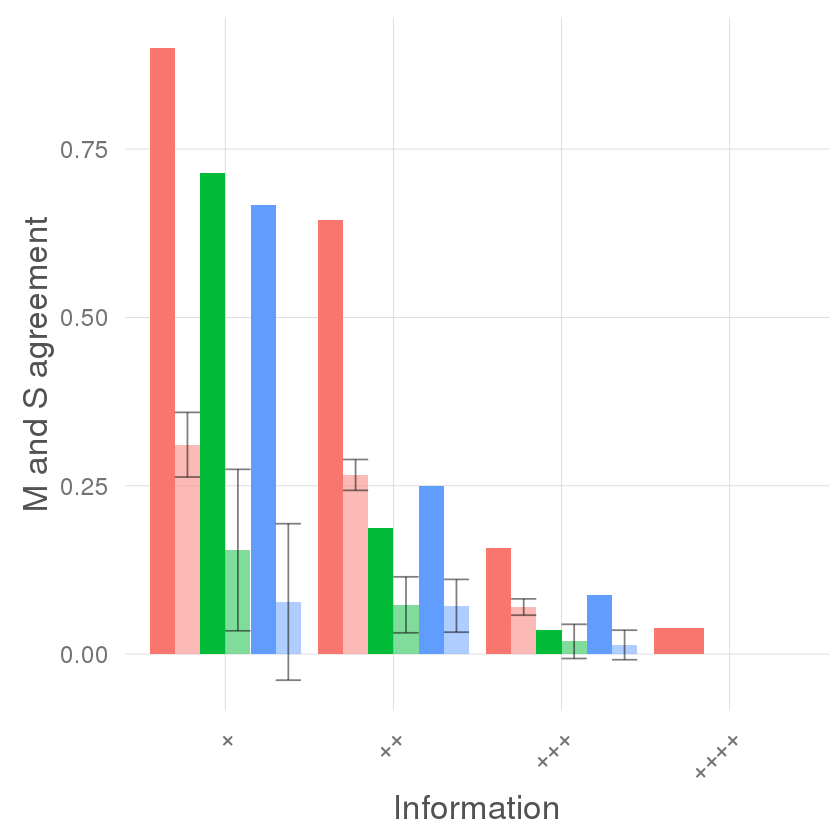

In [11]:
# Read pfam annotation
pfam2go <- read_tsv("~/smartas/data/PFAM2GO.txt",skip=1)
go.levels <- read_tsv("../data/PFAMGO.txt",skip=1)

pfam2go.m <- merge(pfam2go,go.levels) 

# Get list of all observed domains with their associated annotation
domains <- plyr::dlply(pfam2go.m,.(slim_level,GO_subontology,GO_ID),function(x){
    intersect(pf$id,unlist(strsplit(x[,3],",")))
}) %>% unlist 
class <- gsub("\\.[^\\.]+$","",names(domains))

expressedgos <- unlist(strsplit(names(domains),".",fixed=T))[c(F,F,T)] %>% 
    substr(1,10) %>%
    split(class) %>%
    lapply(unique)

# read GO term enrichment analysis and calculate an agreement between M and S
## molecular function
smf <- read_tsv("../results/pfam_go_term/S_GO_molecular_function.tsv",skip=15) %>%
    mutate(origin="switches", gotype="molecular_function")
mmf <- read_tsv("../results/pfam_go_term/M_GO_molecular_function.tsv",skip=15) %>%
    mutate(origin="mutations", gotype="molecular_function")

## cellular component
scc <- read_tsv("../results/pfam_go_term/S_GO_cellular_component.tsv",skip=15) %>%
    mutate(origin="switches", gotype="cellular_component")
mcc <- read_tsv("../results/pfam_go_term/M_GO_cellular_component.tsv",skip=15) %>%
    mutate(origin="mutations", gotype="cellular_component")

## biological process
sbp <- read_tsv("../results/pfam_go_term/S_GO_biological_process.tsv",skip=15) %>%
    mutate(origin="switches", gotype="biological_process")
mbp <- read_tsv("../results/pfam_go_term/M_GO_biological_process.tsv",skip=15) %>%
    mutate(origin="mutations", gotype="biological_process")

go <- do.call("rbind",list(smf,mmf,scc,mcc,sbp,mbp)) %>%
    set_colnames(c("group","id","goterm","slim_level","z","p","fdr","table","domains","origin","gotype")) 

all <- go %>%
    count(id,gotype,slim_level) %>%
    group_by(gotype,slim_level)  %>%
    summarise(Match = sum(n==2), Any=n())

M <- go %>% 
    filter(origin=="mutations") %>%
    count(gotype,slim_level) %>%
    mutate(M = n) %>%
    select(-n)

S <- go %>% 
    filter(origin=="switches") %>%
    count(gotype,slim_level) %>%
    mutate(S = n) %>%
    select(-n)

coincidence <- merge(all,M) %>%
    merge(S) %>%
    mutate(MatchPerc = Match/Any, 
           Coincidence = "Observed", 
           sd = NA, 
           sdPerc = NA,
           slim_level = revalue(as.character(slim_level),
                                replace = c('1'="Least Informative", '2'="Moderately Informative",
                                            '3'="Informative", '4'="Highly Informative")))

# prepare df to get number of samples
M <- unique(coincidence[,c('gotype','slim_level',"M","S")])
rand <- list()
for (c in names(expressedgos)){
    # select real data comparison
    v <- paste(M$slim_level,M$gotype,sep=".")==c
    if (sum(v)==0) next
    x <- M[v,]
    tmp <- list()
    # permutate 100 times
    for (i in 1:100){
        m <- sample(expressedgos[[c]],x$M)
        s <- sample(expressedgos[[c]],x$S)
        tmp[[i]] <- length(intersect(m,s))/length(unique(c(m,s)))
    }
    tmp <- do.call("rbind",tmp)
    rand[[c]] <- data.frame(slim_level=x$slim_level,gotype=x$gotype,Match=mean(tmp),sd=sd(tmp))
}
    
rand <- do.call("rbind",rand) %>%
    mutate(MatchPerc=Match, sdPerc=sd, Coincidence="Random (x100)")
    
coincidence %>%
    select(gotype,slim_level,Match,sd,MatchPerc,sdPerc,Coincidence) %>%
    rbind(rand) %>%
    mutate(slim_level=factor(revalue(slim_level, 
                                     replace = c('Least Informative'="+",
                                                 'Moderately Informative'="++",
                                                 'Informative'="+++",
                                                 'Highly Informative'="++++")),
                                     levels = c('+','++','+++','++++')),
          gotype = gsub("_"," ",gotype))  %>%
    ggplot(aes(fill=gotype,y=MatchPerc,x=slim_level,alpha=Coincidence)) +
        geom_bar(position="dodge",stat="identity") +
        geom_errorbar(aes( ymax = MatchPerc+sdPerc, ymin = MatchPerc-sdPerc),position="dodge") +
        scale_alpha_discrete(range=c("Observed"=1,"Random (x100)"=0.5)) +
        labs(x="Information",y="M and S agreement",fill="GO Ontology") +
        clean_theme() +
        theme(axis.text.x = element_text(angle=45, hjust=1))

In [12]:
all <- go %>%
    count(id,gotype,slim_level) %>%
    group_by(gotype,slim_level)  %>%
    summarise(Match = sum(n==2), Any=n())

M <- go %>% 
    filter(origin=="mutations") %>%
    count(gotype,slim_level) %>%
    mutate(M = n) %>%
    select(-n)

S <- go %>% 
    filter(origin=="switches") %>%
    count(gotype,slim_level) %>%
    mutate(S = n) %>%
    select(-n)

In [13]:
# some molecular function terms
x <- table(rbind(mmf[,c(3,4)],smf[,c(3,4)]))
rownames(x)[x[,1]==2]
rownames(x)[x[,2]==2]
rownames(x)[x[,3]==2]

[1] "molecular transducer activity" "receptor activity"

[1] "calcium ion binding"                           
[2] "cell adhesion molecule binding"                
[3] "heparin binding"                               
[4] "protein complex binding"                       
[5] "protein domain specific binding"               
[6] "protein tyrosine kinase activity"              
[7] "receptor binding"                              
[8] "transmembrane receptor protein kinase activity"

[1] "collagen binding"                     
[2] "PDZ domain binding"                   
[3] "phosphatidylinositol 3-kinase binding"

### Genes containing the domains

We will inquire if gained/lost domains are characteristic of certain either oncogenes or tumor suppressors. We will clasify all the domains present in the reference proteome that occur in oncogenes suppresors as gained or lost (those outside those categories are omited).


	Fisher's Exact Test for Count Data

data:  .
p-value = 9.499e-06
alternative hypothesis: true odds ratio is not equal to 1
95 percent confidence interval:
 0.5965483 0.8250954
sample estimates:
odds ratio 
  0.702362 


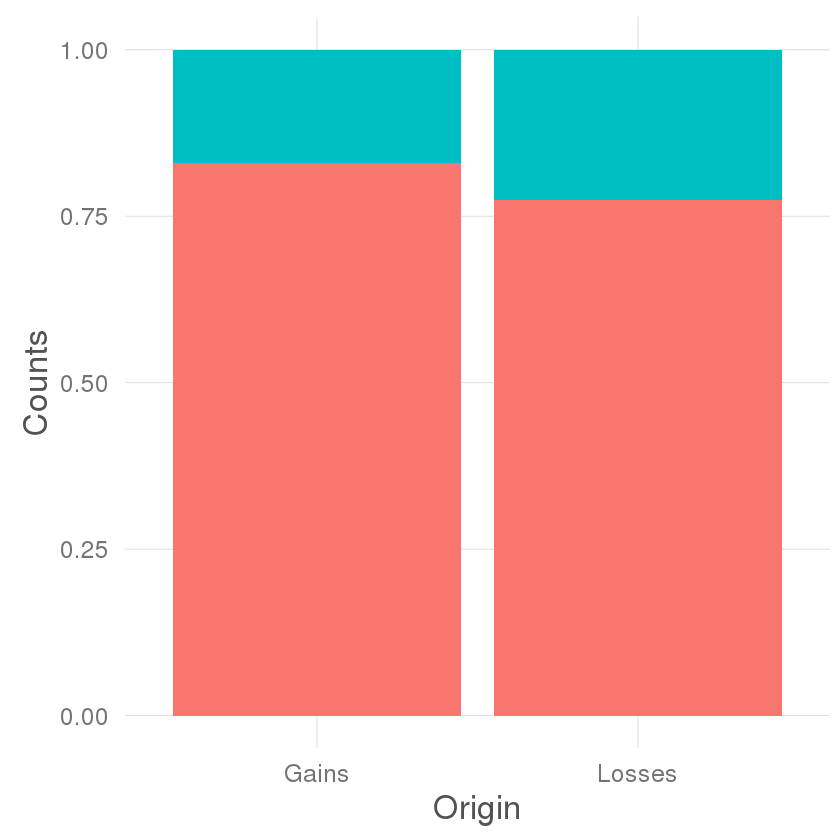

In [41]:
L <- pf.all$adjp_l < 0.05 & pf.all$switches_l > 1
L[is.na(L)] <- FALSE
G <- pf.all$adjp_g < 0.05 & pf.all$switches_g > 1
G[is.na(G)] <- FALSE

driver.types <- read_tsv("../data/cancer_networks_SuppTables_v7_S7.csv", col_names = F) %>%
    set_colnames(c("Symbol","Driver_type"))

g.counts <- features %>%
    filter(Feature %in% pf.all$Feature[G]) %>%
    select(Symbol) %>%
    merge(driver.types) %>%
    .$Driver_type %>%
    table

l.counts <- features %>%
    filter(Feature %in% pf.all$Feature[L]) %>%
    select(Symbol) %>%
    merge(driver.types) %>%
    .$Driver_type %>%
    table

rbind(l.counts,g.counts) %>%
    as.data.frame %>%
    mutate(Origin = c("Losses","Gains")) %>%
    melt(id.vars = "Origin") %>%
    set_colnames(c("Origin","Driver_type","Counts")) %>%
    filter(Driver_type != "Unknown" & Driver_type != "oncogene/suppressor") %>%
    ggplot(aes(x = Origin, y = Counts, fill = Driver_type)) +
        geom_bar(stat = "identity", position = "fill") +
        clean_theme()

rbind(l.counts,g.counts) %>%
    as.data.frame %>%
    mutate(Origin = c("Losses","Gains")) %>%
    select(oncogene,suppressor) %>%
    fisher.test

## Coincidence in genes
We will check if the domains affected by mutations and switches tend to co-occurr in the same genes.

In [14]:
M <- pf.all$adjp_m < 0.05
M[is.na(M)] <- FALSE
S <- (pf.all$adjp_l < 0.05 & pf.all$switches_l > 1) | (pf.all$adjp_g < 0.05 & pf.all$switches_g > 1)
S[is.na(S)] <- FALSE

# get the genes with a switch involving a MS domain
s.genes <- switches.pfam %>%
    filter(Feature %in% pf.all$Feature[M&S]) %>%
    select(GeneId,Symbol,Feature) %>%
    unique %>%
    mutate(Switched=TRUE)

# get the genes with a mutation involving a MS domain
m.genes <- read_tsv("../data/mutations/proteome_mutations.txt") %>%
    filter(Analysis=="Pfam") %>%
    filter(Feature %in% pf.all$Feature[M&S]) %>%
    select(GeneId,Symbol,Feature) %>%
    unique %>%
    mutate(Mutated=TRUE)

# check all genes containing this feature in the proteome
all.genes <- features %>%
    filter(Feature %in% pf.all$Feature[M&S]) %>%
    select(GeneId,Symbol,Feature) %>%
    unique

# merge to see coincidence between genes
x <- merge(s.genes,m.genes,all=T) %>%
    merge(all.genes,all=T) %>%
    mutate(Switched=ifelse(is.na(Switched),FALSE,TRUE),
           Mutated=ifelse(is.na(Mutated),FALSE,TRUE)) %>%
    group_by(Feature) %>%
    summarise(MS=sum(Mutated&Switched), M=sum(Mutated), 
              S=sum(Switched), N=length(GeneId)) %>%
    mutate(M=M-MS, S=S-MS, 
           N=N-(MS+S+M), J=MS/(M+S+MS)) %>%
    arrange(desc(J))

x

,Feature,MS,M,S,N,J
1,PF00683|TB_domain,3,4,0,0,0.4285714
2,"PF00969|Class_II_histocompatibility_antigen,_beta_domain",2,3,1,2,0.3333333
3,PF10409|C2_domain_of_PTEN_tumour-suppressor_protein,2,4,0,1,0.3333333
4,PF00041|Fibronectin_type_III_domain,29,90,4,7,0.2357724
5,PF07679|Immunoglobulin_I-set_domain,31,99,7,7,0.2262774
6,PF00090|Thrombospondin_type_1_domain,9,38,3,5,0.18
7,PF01833|IPT/TIG_domain,4,18,1,0,0.173913
8,PF07645|Calcium-binding_EGF_domain,12,57,1,1,0.1714286
9,PF04103|CD20-like_family,2,12,1,3,0.1333333
10,PF00413|Matrixin,2,16,0,1,0.1111111


In [15]:
switches.pfam %>%
    filter(Feature=="PF00683|TB_domain") %>%
    select(GeneId,Symbol,WhatsHappenning) %>%
    unique

,GeneId,Symbol,WhatsHappenning
1,4054,LTBP3,Lost_in_tumor
10,8425,LTBP4,Lost_in_tumor
26,2201,FBN2,Lost_in_tumor
